In [32]:
import json
import pandas as pd
from datetime import datetime
from collections import defaultdict

# Load the data
with open('user-wallet-transactions.json', 'r') as f:
    transactions = json.load(f)

# Group transactions by userWallet
user_groups = defaultdict(list)

for txn in transactions:
    user = txn.get('userWallet')
    if not user:
        continue
    user_groups[user].append(txn)

# Create features per wallet
features = []

for user, txns in user_groups.items():
    deposit_usd = 0.0
    borrow_usd = 0.0
    withdraw_usd = 0.0
    repay_usd = 0.0
    timestamps = []

    for txn in txns:
        action = txn.get("action", "").lower()
        ts = txn.get("timestamp")
        timestamps.append(datetime.fromtimestamp(ts).date() if ts else None)

        # Calculate amount in USD
        try:
            amount = float(txn["actionData"]["amount"]) / 1e6
            price = float(txn["actionData"]["assetPriceUSD"])
            amount_usd = amount * price
        except (KeyError, ValueError):
            amount_usd = 0.0

        if action == "deposit":
            deposit_usd += amount_usd
        elif action == "borrow":
            borrow_usd += amount_usd
        elif action == "withdraw":
            withdraw_usd += amount_usd
        elif action == "repay":
            repay_usd += amount_usd

    total_txns = len(txns)
    active_days = len(set(timestamps))

    features.append({
        "userWallet": user,
        "total_deposit_usd": deposit_usd,
        "total_borrow_usd": borrow_usd,
        "total_withdraw_usd": withdraw_usd,
        "total_repay_usd": repay_usd,
        "deposit_to_borrow_ratio": deposit_usd / (borrow_usd + 1e-6),
        "borrow_to_repay_ratio": borrow_usd / (repay_usd + 1e-6),
        "transaction_count": total_txns,
        "active_days": active_days,
    })

df = pd.DataFrame(features)
df.head()


,userWallet,total_deposit_usd,total_borrow_usd,total_withdraw_usd,total_repay_usd,deposit_to_borrow_ratio,borrow_to_repay_ratio,transaction_count,active_days
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,1.987664e+03,0.000000e+00,0.0,0.000000,1.987664e+09,0.000000e+00,1,1
1,0x000000000051d07a4fb3bd10121a343d85818da6,2.856945e+14,0.000000e+00,0.0,0.000000,2.856945e+20,0.000000e+00,1,1
2,0x000000000096026fb41fc39f9875d164bd82e2dc,5.152311e+09,0.000000e+00,0.0,0.000000,5.152311e+15,0.000000e+00,2,2
3,0x0000000000e189dd664b9ab08a33c4839953852c,0.000000e+00,0.000000e+00,0.0,0.000000,0.000000e+00,0.000000e+00,17,8
4,0x0000000002032370b971dabd36d72f3e5a7bf1ee,2.065773e+17,6.029762e+16,0.0,70150.263791,3.425962e+00,8.595495e+11,399,101


In [34]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Features to use for score computation
score_features = df[['total_deposit_usd', 'deposit_to_borrow_ratio', 'transaction_count', 'active_days']].fillna(0)

# Log scale to reduce skew
score_features = np.log1p(score_features)

# Normalize to 0-1
scaler = MinMaxScaler()
normalized = scaler.fit_transform(score_features)

# Weighted scoring (customize weights as needed)
weights = np.array([0.4, 0.3, 0.2, 0.1])
weighted_score = np.dot(normalized, weights)

# Scale to 0–1000
df['credit_score'] = (weighted_score * 1000).astype(int)

# Show a few results
df[['userWallet', 'credit_score']].head()


,userWallet,credit_score
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,177
1,0x000000000051d07a4fb3bd10121a343d85818da6,535
2,0x000000000096026fb41fc39f9875d164bd82e2dc,402
3,0x0000000000e189dd664b9ab08a33c4839953852c,86
4,0x0000000002032370b971dabd36d72f3e5a7bf1ee,575


In [36]:
from sklearn.model_selection import train_test_split

X = df.drop(['userWallet', 'credit_score'], axis=1)
y = df['credit_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [38]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score

model = XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))


MAE: 3.685246792946543
R2 Score: 0.9981229234535387


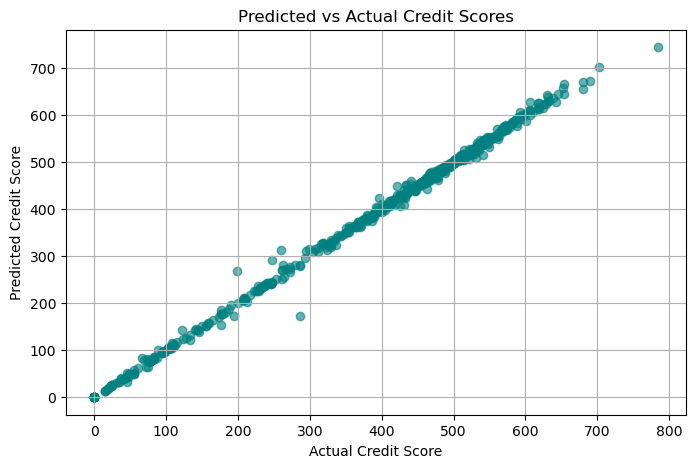

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.6, color='teal')
plt.xlabel("Actual Credit Score")
plt.ylabel("Predicted Credit Score")
plt.title("Predicted vs Actual Credit Scores")
plt.grid(True)
plt.show()


In [46]:
import joblib

joblib.dump(model, 'model.pkl')


['model.pkl']